# Simple example of clustering with 2 attributes using SciKit Learn's k-Means and GMM (Gaussian Mixture Models) algorithms.

## Both models will be exported into ONNX format with the proper metadata.json required by OML Services for scoring

Copyright (c) 2021 Oracle Corporation                             
###### [The Universal Permissive License (UPL), Version 1.0](https://oss.oracle.com/licenses/upl/)
---

In [45]:
import sklearn
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import skl2onnx
from skl2onnx import to_onnx

import onnxmltools
import json

from zipfile import ZipFile

# Loads the Breast Cancer dataset
bc=datasets.load_breast_cancer(as_frame=True)
# Creates a Pandas Dataframe
df = pd.DataFrame(bc.data, columns = bc.feature_names)

#Check the whole input dataset
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Text(0.5, 1.0, 'Original Data Scatter Plot')

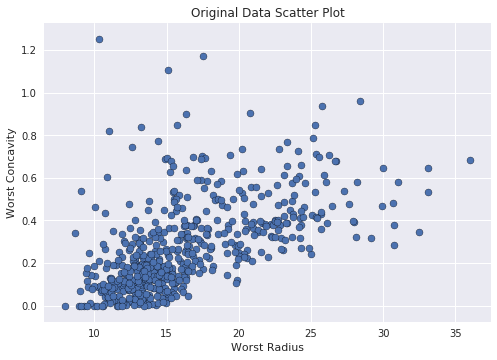

In [46]:
# Let's plot two of the attributes to see the dispersion patterns

# Set a nicer looking chart style
plt.style.use('seaborn')

# Generate a Scatterplot of two attributes
plt.scatter(df['worst radius'], df['worst concavity'], cmap='plasma', edgecolor='k')
plt.xlabel("Worst Radius")
plt.ylabel("Worst Concavity")
plt.title("Original Data Scatter Plot")

In [47]:
# Let's create a subset with only the 2 attributes
df_sub = df[['worst radius','worst concavity']]
# Check the first 5 rows of the sub-selection
df_sub.head(5)

,worst radius,worst concavity
0,25.38,0.7119
1,24.99,0.2416
2,23.57,0.4504
3,14.91,0.6869
4,22.54,0.4000


## k-Means clustering model
### Build Model
---

In [48]:
# Define a k-Means clustering model with 2 clusters,
# and initialization by k-means++
from sklearn.cluster import KMeans
km_clus = sklearn.cluster.KMeans(init='k-means++', n_clusters=2)

# fit the model on the first 2 columns
km_clus.fit(df_sub)

# Return the predicted labels of the model
km_pred_labels=km_clus.predict(df_sub)

# Print the first 10 predicted labels
print(km_pred_labels[0:10])

[0 0 0 1 0 1 0 1 1 1]


### Plot k-Means cluster predictions

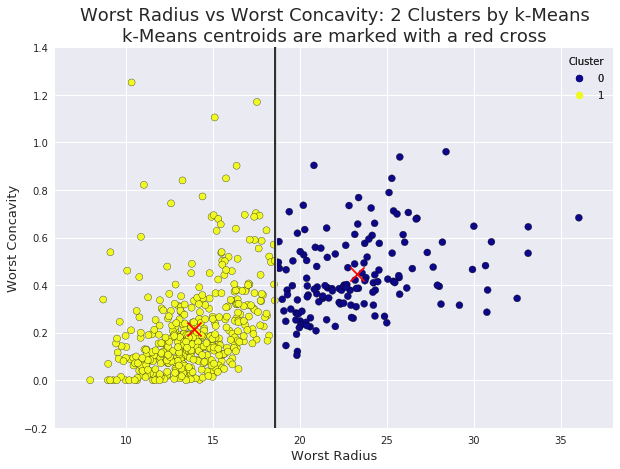

In [49]:
# Let's plot the resulting k-Means predictions on the original scatterplot
fig_km, ax_km = plt.subplots(figsize=[10,7])
# Set a nicer looking default chart style
plt.style.use('seaborn')

# Generate the original Scatterplot of Worst Radius and Worst Concavity
# this time with colors per cluster by k-Means
scat = ax_km.scatter(df_sub['worst radius'], df_sub['worst concavity'], c=km_pred_labels, cmap='plasma', edgecolor='k')

# Plot the centroids as a Red X
centroids = km_clus.cluster_centers_
ax_km.scatter(centroids[:, 0], centroids[:, 1], 
            marker='x', s=200, linewidths=3,
            color='r', zorder=10)

# Create a Mesh Grid on the original plot dimensions for finding the 
# decision boundaries for each cluster (with a minor adjustment of 0.2)
x_min, x_max = df_sub.iloc[:, 0].min() - 2, df_sub.iloc[:, 0].max() + 2
y_min, y_max = df_sub.iloc[:, 1].min() - 0.2, df_sub.iloc[:, 1].max() + 0.2
WRadius_X, Wconcavity_Y = np.meshgrid(np.arange(x_min, x_max, 0.1), 
                                      np.arange(y_min, y_max, 0.1))
# Score k-Means cluster model across the mesh
final_grid_km = km_clus.predict(np.c_[WRadius_X.ravel(), Wconcavity_Y.ravel()])

# Draw a contour plot to illustrate the model cluster separation
final_grid_km = final_grid_km.reshape(WRadius_X.shape)
ax_km.contour(WRadius_X, Wconcavity_Y, final_grid_km)

ax_km.set_xlabel('Worst Radius', size=13)
ax_km.set_ylabel("Worst Concavity", size=13)
ax_km.set_title("Worst Radius vs Worst Concavity: 2 Clusters by k-Means\n"
                "k-Means centroids are marked with a red cross", size=18)

# Add a legend to the chart
legend1 = ax_km.legend(*scat.legend_elements(num=1),
                    loc="upper right", title="Cluster")
ax_km.add_artist(legend1)


### Export the k-Means model to ONNX format

We will create and add the metadata.json file needed by OML Services to the Zip file

In [50]:
# Write the GMM model to ONNX format. Input data needs to be a numpy format
clus_onnx = to_onnx(km_clus, df_sub.to_numpy(), target_opset=12)
# Export the model to a file on disk
onnxmltools.utils.save_model(clus_onnx, './clus_onnx.onnx')
# Create the metadata.json file needed by Oracle Machine Learning Services
metadata = {"function":"clustering","clusteringDistanceOutput":"scores"}
with open('./metadata.json', mode='w') as f: 
       json.dump(metadata, f)
# Write the final ZIP File to be used in OML Services
with ZipFile('./clus_onnx.zip', mode='w') as zf:
    zf.write('./metadata.json')
    zf.write('./clus_onnx.onnx')

## Gaussian Mixture Model (GMM) clustering
### Build Model
---

In [51]:
# Define a Gaussian Mixture Model with 2 clusters
from sklearn import cluster, datasets, mixture
gmm_clus = mixture.GaussianMixture(n_components=2, covariance_type="full", random_state=1)

# Fit the model on the first 2 columns
gmm_clus.fit(df_sub)

# Return the predicted probabilities of the model
gmm_clus_pred=gmm_clus.predict_proba(df_sub)

# Print the first 10 sets of predicted probabilities
# Probabilities of belonging to Cluster 0 and 1
gmm_probs_df = pd.DataFrame(gmm_clus.predict_proba(df_sub), 
                            columns={'Prob_of_Cluster0','Prob_of_Cluster1'})
gmm_probs_df.head(10).round(4)

,Prob_of_Cluster0,Prob_of_Cluster1
0,1.0000,0.0000
1,1.0000,0.0000
2,0.9999,0.0001
3,1.0000,0.0000
4,0.9990,0.0010
5,0.9964,0.0036
6,0.9994,0.0006
7,0.1984,0.8016
8,0.9969,0.0031
9,1.0000,0.0000


In [52]:
# Return the predicted labels of the model
gmm_clus_labels=gmm_clus.predict(df_sub)

# Print the first 10 predicted labels
print(gmm_clus_labels[0:10])

[0 0 0 0 0 0 0 1 0 0]


### Plot GMM cluster predictions

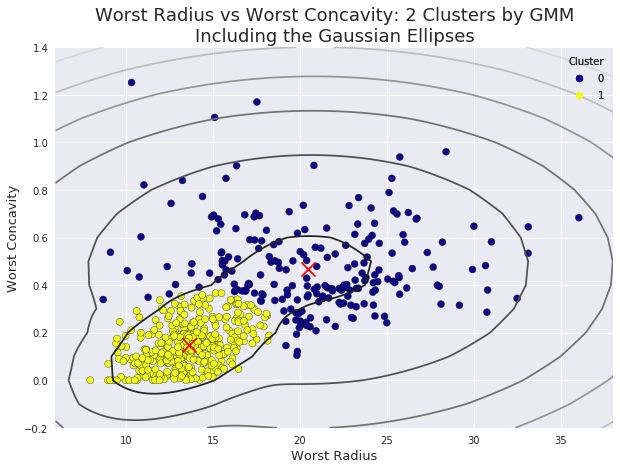

In [53]:
# Let's plot the resulting GMM predictions on the original scatterplot
# and also see the Elipsoids that represent the Gaussian distributions
fig_gmm, ax_gmm = plt.subplots(figsize=[10,7])

# Set a nicer looking default chart style
plt.style.use('seaborn')

# Generate the original Scatterplot of Worst Radius and Worst Concavity
# this time with colors per cluster by GMM
scat = ax_gmm.scatter(df_sub['worst radius'], df_sub['worst concavity'], 
                      c=gmm_clus_labels, cmap='plasma', edgecolor='k')
ax_gmm.set_xlabel('Worst Radius', size=13)
ax_gmm.set_ylabel("Worst Concavity", size=13)
ax_gmm.set_title("Worst Radius vs Worst Concavity: 2 Clusters by GMM\n"
                 "Including the Gaussian Ellipses", size=18)

# Plot the centroids as a Red X
gmm_means = gmm_clus.means_
ax_gmm.scatter(gmm_means[:, 0], gmm_means[:, 1], 
            marker='x', s=200, linewidths=3,
            color='r', zorder=10)

# Create a Mesh Grid on the original plot dimensions for finding the 
# decision boundaries for each GMM ellipses (with a minor adjustment of 0.2)
x_min, x_max = df_sub.iloc[:, 0].min() - 2, df_sub.iloc[:, 0].max() + 2
y_min, y_max = df_sub.iloc[:, 1].min() - 0.2, df_sub.iloc[:, 1].max() + 0.2
WRadius_X, Wconcavity_Y = np.meshgrid(np.arange(x_min, x_max, 0.1), 
                                      np.arange(y_min, y_max, 0.1))
Grid_Rad_Conc = np.array([WRadius_X.ravel(), Wconcavity_Y.ravel()]).T
# Score GMM cluster model across the mesh
Final_Grid = gmm_clus.score_samples(Grid_Rad_Conc)
# Reshape the mesh to conform with the shape of the original data
Final_Grid = Final_Grid.reshape(WRadius_X.shape)
# Plot the ellipsis
ax_gmm.contour(WRadius_X, Wconcavity_Y, Final_Grid)

# Add a legend to the chart
leg_gmm = ax_gmm.legend(*scat.legend_elements(num=1),
                        loc="upper right", title="Cluster")
ax_gmm.add_artist(leg_gmm)


In [54]:
# Check the weights, means and covariances
print('GMM weights:')
print(gmm_clus.weights_)
print('\nGMM Means:')
print(gmm_clus.means_)
print('\nGMM Covariances:')
print(gmm_clus.covariances_)

GMM weights:
[0.38740444 0.61259556]

GMM Means:
[[20.45976511  0.46609291]
 [13.61907682  0.14956364]]

GMM Covariances:
[[[2.44852455e+01 1.51286739e-02]
  [1.51286739e-02 3.55704453e-02]]

 [[4.45314937e+00 9.46955958e-02]
  [9.46955958e-02 9.61637687e-03]]]


### Export the GMM model to ONNX format

We will create and add the metadata.json file needed by OML Services to the Zip file

In [55]:
# Write the GMM model to ONNX format. Input data needs to be a numpy format
gmm_onnx = to_onnx(gmm_clus, df_sub.to_numpy(), target_opset=12)
# Export the model to a file on disk
onnxmltools.utils.save_model(gmm_onnx, './gmm_onnx.onnx')
# Create the metadata.json file needed by Oracle Machine Learning Services
# In this example we will return the Probabilities
metadata = {"function":"clustering","clusteringProbOutput":"probabilities"}
with open('./metadata.json', mode='w') as f: 
       json.dump(metadata, f)
# Write the final ZIP File to be used in OML Services
with ZipFile('./gmm_onnx.zip', mode='w') as zf:
    zf.write('./metadata.json')
    zf.write('./gmm_onnx.onnx')

## Extra useful verification for ONNX information

In [58]:
# Check the k-Means ONNX model
print(clus_onnx)

ir_version: 7
producer_name: "skl2onnx"
producer_version: "1.10.3"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    output: "Re_reduced0"
    name: "Re_ReduceSumSquare"
    op_type: "ReduceSumSquare"
    attribute {
      name: "axes"
      ints: 1
      type: INTS
    }
    attribute {
      name: "keepdims"
      i: 1
      type: INT
    }
    domain: ""
  }
  node {
    input: "Re_reduced0"
    input: "Mu_Mulcst"
    output: "Mu_C0"
    name: "Mu_Mul"
    op_type: "Mul"
    domain: ""
  }
  node {
    input: "X"
    input: "Ge_Gemmcst"
    input: "Mu_C0"
    output: "Ge_Y0"
    name: "Ge_Gemm"
    op_type: "Gemm"
    attribute {
      name: "alpha"
      f: -2.0
      type: FLOAT
    }
    attribute {
      name: "transB"
      i: 1
      type: INT
    }
    domain: ""
  }
  node {
    input: "Re_reduced0"
    input: "Ge_Y0"
    output: "Ad_C01"
    name: "Ad_Add"
    op_type: "Add"
    domain: ""
  }
  node {
    input: "Ad_Addcst"
    input: "A

In [57]:
# Check the GMM ONNX model
print(gmm_onnx)

ir_version: 7
producer_name: "skl2onnx"
producer_version: "1.10.3"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    input: "Ge_Gemmcst"
    input: "Ge_Gemmcst1"
    output: "Ge_Y0"
    name: "Ge_Gemm"
    op_type: "Gemm"
    attribute {
      name: "alpha"
      f: 1.0
      type: FLOAT
    }
    attribute {
      name: "beta"
      f: 1.0
      type: FLOAT
    }
    domain: ""
  }
  node {
    input: "X"
    input: "Ge_Gemmcst2"
    input: "Ge_Gemmcst3"
    output: "Ge_Y02"
    name: "Ge_Gemm1"
    op_type: "Gemm"
    attribute {
      name: "alpha"
      f: 1.0
      type: FLOAT
    }
    attribute {
      name: "beta"
      f: 1.0
      type: FLOAT
    }
    domain: ""
  }
  node {
    input: "Ge_Y0"
    output: "Re_reduced0"
    name: "Re_ReduceSumSquare"
    op_type: "ReduceSumSquare"
    attribute {
      name: "axes"
      ints: 1
      type: INTS
    }
    domain: ""
  }
  node {
    input: "Ge_Y02"
    output: "Re_reduced02"
    name: "Re_R